# PyOR Quantum
## Author: Vineeth Thalakottoor
## Introduction to powder average Dipole

In [1]:
# Define the source path
SourcePath = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/PyOR_Combined/PyOR/Source_Doc'

# Add source path
import sys
sys.path.append(SourcePath)
%matplotlib ipympl
from joblib import Parallel, delayed

# Import PyOR package
from PyOR_QuantumSystem import QuantumSystem as QunS
from PyOR_Hamiltonian import Hamiltonian
from PyOR_QuantumLibrary import QuantumLibrary
import PyOR_SphericalTensors as ST
import PyOR_Rotation as Rot
QLib = QuantumLibrary()
from PyOR_DensityMatrix import DensityMatrix
from PyOR_HardPulse import HardPulse
from PyOR_Basis import Basis
from PyOR_Evolution import Evolutions
from PyOR_Plotting import Plotting
import PyOR_SignalProcessing as Spro
import PyOR_CrystalOrientation as CO
import time
import numpy as np

In [2]:
# Define the spin system
Spin_list = {"A" : "H2"}
QS = QunS(Spin_list,PrintDefault=False)

# initialize the system
QS.Initialize()

### Set parameters

In [3]:
# Master Equation
QS.PropagationSpace = "Hilbert"
QS.MasterEquation = "Redfield"

# B0 Field in Tesla, Static Magnetic field (B0) along Z
QS.B0 = QS.L100

# Offset Frequency in rotating frame (Hz)
QS.OFFSET["A"] = 0.0

# Define initial and final Spin Temperature
QS.I_spintemp["A"] = 300.0
QS.F_spintemp["A"] = 300.0

# Relaxation Process
QS.Rprocess = "Phenomenological"
QS.R1 = 1
QS.R2 = 2

QS.Update()

Rotating frame frequencies: {'A': -96482012.17500001}
Offset frequencies: {'A': 0.0}
Initial spin temperatures: {'A': 300.0}
Final spin temperatures: {'A': 300.0}
Radiation damping gain: {'A': 0}
Radiation damping phase: {'A': 0}

Rprocess = Phenomenological
RelaxParDipole_tau = 0.0
DipolePairs = []
RelaxParDipole_bIS = []


### Zeeman Hamiltonians

In [4]:
# generate Larmor Frequencies
QS.print_Larmor = True
Ham = Hamiltonian(QS)

# Lab Frame Hamiltonian
Hz_lab = Ham.Zeeman()

# Rotating Frame Hamiltonian
Hz = Ham.Zeeman_RotFrame()

Larmor Frequency in MHz:  [-15.35558916]


### Dipole tensor PAF

In [5]:
QuadrupoleCoupling = 100 # Hz
eta = 0.5

A = "A"

IT_PAF = Ham.InteractionTensor_PAF_Quadrupole(A,QuadrupoleCoupling,eta)
IT_PAF.Inverse2PI().matrix

Matrix([
[-37.5,     0,    0],
[    0, -12.5,    0],
[    0,     0, 50.0]])

In [6]:
PAF_Decom = Ham.InteractionTensor_PAF_Decomposition(IT_PAF)
PAF_Decom

{'Isotropic': 0.0, 'Anisotropy': 50.0, 'Asymmetry': 0.4999999999999999}

### Density Matrix

In [7]:
#--------------------------    
# Initialize Density Matrix
#--------------------------
DM = DensityMatrix(QS,Ham)

# High Temperature
HT_approx = False

# Initial Density Matrix
rho_in = QS.Ax

# Equlibrium Density Matrix
rhoeq = DM.EquilibriumDensityMatrix(QS.Fspintemp,HT_approx)


Trace of density matrix =  1.0


### Evolution

In [8]:
QS.AcqDT = 0.0001
QS.AcqAQ = 5.0
QS.Update()

QS.PropagationMethod = "Unitary Propagator"

EVol = Evolutions(QS,Ham)
EVol.Update()

A = "A"
B = "A"

# Generate 1000 random angles
if False:
    N = 1000
    beta = np.linspace(0, 180, N) 
    alpha = np.linspace(0, 360, N)  
    gamma = np.zeros(N)
else:
    alpha, beta, gamma, weight = CO.Load_Crystallite_CSV("rep2000_cryst.csv")

rhoI = rho_in

start_time = time.time()
freq, spectrum = Ham.PowderSpectrum(EVol,rhoI, rhoeq, A, IT_PAF, B, "spin-spin", "secular + pseudosecular", gamma, beta, alpha, weighted=True, weight = weight, SecularEquation="spherical")
end_time = time.time()
print("Total time = %.2f seconds" % (end_time - start_time)) 

Rotating frame frequencies: {'A': -96482012.17500001}
Offset frequencies: {'A': 0.0}
Initial spin temperatures: {'A': 300.0}
Final spin temperatures: {'A': 300.0}
Radiation damping gain: {'A': 0}
Radiation damping phase: {'A': 0}

Rprocess = Phenomenological
RelaxParDipole_tau = 0.0
DipolePairs = []
RelaxParDipole_bIS = []
Larmor Frequency in MHz:  [-15.35558916]
Total time = 111.73 seconds


### Plotting

In [9]:
plot = Plotting(QS)
plot.PlotFigureSize = (10,5)
plot.PlotFontSize = 20
plot.PlotXlimt = (-200,200)

(<Figure size 1000x500 with 1 Axes>,
 <matplotlib.widgets.SpanSelector at 0x7f54778f7500>)

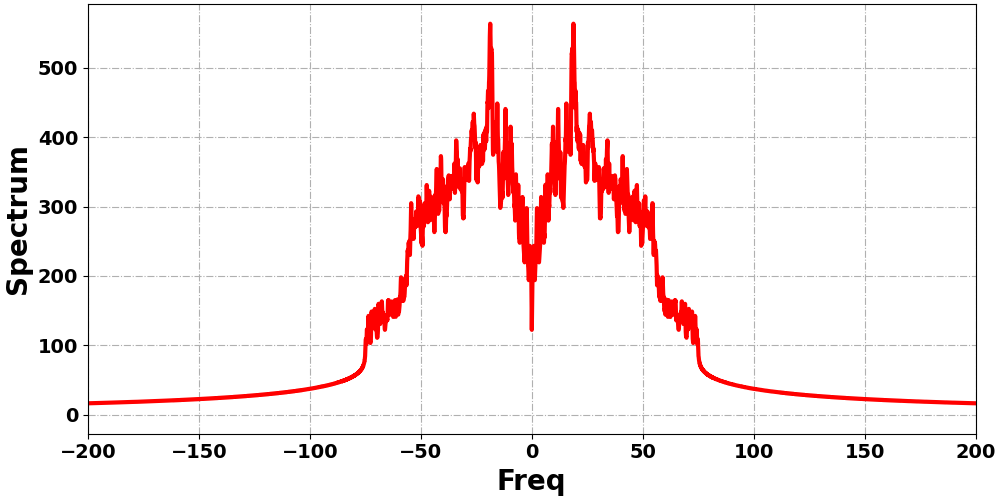

In [10]:
plot.Plotting_SpanSelector(freq, np.abs(spectrum), "Freq", "Spectrum", "red")